<a href="https://colab.research.google.com/github/LuisPerdomo123/Inteligencia-Computacional/blob/main/Funciones_de_activacion_Caso_Prectico_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso Práctico ¿por qué se requiere una función de activación?

## Conjunto de datos: Detección de transacciones bancarias fraudulentas

### Descripción

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions thar occurred in two days, where we have 492 frauds out of 284.807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172 % of all transactions.

It contains only numerical input vaiables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the second dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos

https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

#### Referencias adicionales sobre el conjunto de datos

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects in related topics are avialable on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Funciones auxiliares

In [10]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
  strat = df[stratify] if stratify else None
  train_set, test_set = train_test_split(
      df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
  strat = test_set[stratify] if stratify else None
  val_set, test_set = train_test_split(
      test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
  return (train_set, val_set, test_set)


In [3]:
def remove_labels(df, label_name):
  X = df.drop(label_name, axis=1)
  y = df[label_name].copy()
  return (X, y)

## 1. Lectura el conjunto de datos

In [4]:
from google.colab import files
import pandas as pd

# Selecciona el archivo CSV desde tu sistema local
uploaded = files.upload()

# Lee el archivo CSV cargado
for fn in uploaded.keys():
  print('Archivo cargado: "{name}" con tamaño {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# Lee el archivo CSV y carga los datos en un DataFrame de pandas
df = pd.read_csv(next(iter(uploaded)))

Saving creditcard.csv to creditcard.csv
Archivo cargado: "creditcard.csv" con tamaño 150828752 bytes


## 2. Visualizción del conjunto de datos

In [5]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


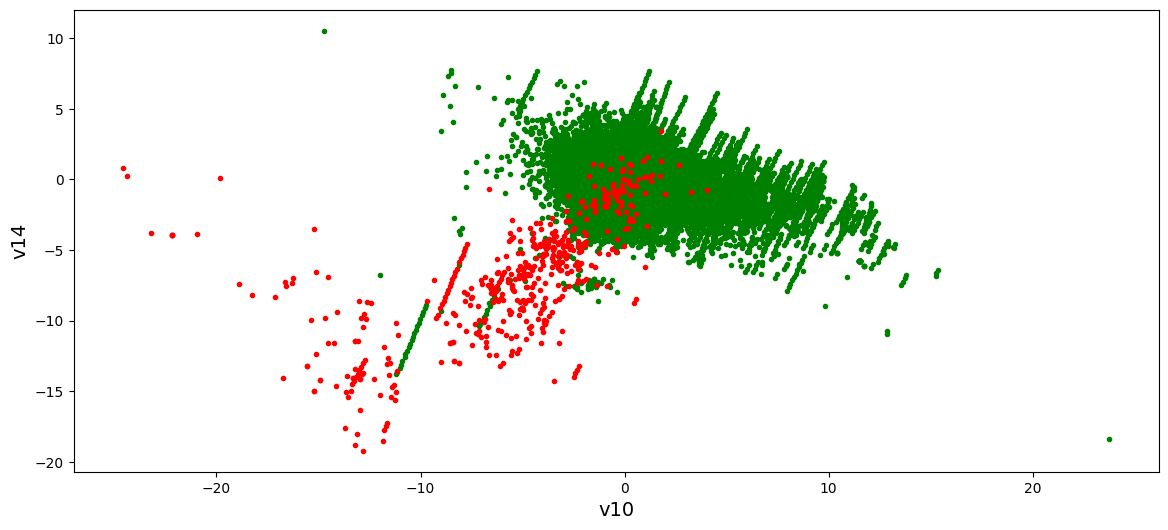

In [6]:
# Representación gráfica de dos características
plt.figure(figsize=(14,6))
plt.scatter(df["V10"][df['Class'] == 0], df["V14"][df['Class']==0], c="g", marker=".")
plt.scatter(df["V10"][df['Class'] == 1], df["V14"][df['Class']==1], c="r", marker=".")
plt.xlabel("v10", fontsize=14)
plt.ylabel("v14", fontsize=14)
plt.show()

## 3. División del conjunto de datos

In [11]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [12]:
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

## 4. Redes Neuronales Artificiales con un conjunto de datos de dos dimensiones

In [19]:
# Reducimos el conjunto de datos y nos quedamos con las características de entrada V10 y V14
X_train_reduced = X_train[["V10", "V14"]].copy()
X_val_reduced = X_val[["V10", "V14"]].copy()
X_tets_reduced = X_test[["V10", "V14"]].copy()

**Entrenamiento del algoritmo eliminando las funciones de activación**

In [20]:
# Definición de la arquitectura de la red neuronal
from tensorflow.keras import models
from tensorflow.keras import layers

activation = None

model = models.Sequential()
model.add(layers.Dense(128, activation=activation, input_shape = (X_train_reduced.shape[1],)))
model.add(layers.Dense(64, activation=activation))
model.add(layers.Dense(32, activation=activation))
model.add(layers.Dense(16, activation=activation))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision'])

In [22]:
# Resumen de las capas del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               384       
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 11265 (44.00 KB)
Trainable params: 11265 (44.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Entrenamos el modelo
history = model.fit(X_train_reduced,
                    y_train,
                    epochs=30,
                    validation_data=(X_val_reduced, y_val))

Epoch 1/30
5341/5341 [==============================] - 17s 3ms/step - loss: 0.0086 - accuracy: 0.9986 - precision: 0.6190 - val_loss: 0.0046 - val_accuracy: 0.9990 - val_precision: 0.8679
Epoch 2/30
5341/5341 [==============================] - 19s 3ms/step - loss: 0.0051 - accuracy: 0.9990 - precision: 0.8392 - val_loss: 0.0046 - val_accuracy: 0.9992 - val_precision: 0.8125
Epoch 3/30
5341/5341 [==============================] - 16s 3ms/step - loss: 0.0052 - accuracy: 0.9990 - precision: 0.8029 - val_loss: 0.0045 - val_accuracy: 0.9991 - val_precision: 0.8194
Epoch 4/30
5341/5341 [==============================] - 17s 3ms/step - loss: 0.0051 - accuracy: 0.9990 - precision: 0.7981 - val_loss: 0.0044 - val_accuracy: 0.9991 - val_precision: 0.8438
Epoch 5/30
5341/5341 [==============================] - 18s 3ms/step - loss: 0.0051 - accuracy: 0.9990 - precision: 0.7850 - val_loss: 0.0045 - val_accuracy: 0.9990 - val_precision: 0.8333
Epoch 6/30
5341/5341 [==============================] -

**Representación del límite de decisión**

In [24]:
def plot_ann_decision_boundary(X, y, model, steps=1000):
  xmin, xmax = X[:,0].min() - 1, X[:,1].max() + 1
  ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
  steps = 1000

  x_span = np.linspace(xmin, xmax, steps)
  y_span = np.linspace(ymin, ymax, steps)
  xx, yy = np.meshgrid(x_span, y_span)

  labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = labels.reshape(xx.shape)

  plt.contourf(xx, yy, Z, cmap="RdBu", alpha=0.5)
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'k.', markersize=2)
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'r.', markersize=2)
  plt.xlabel("V10", fontsize=14)
  plt.ylabel("V14", fontsize=14)

31250/31250 [==============================] - 62s 2ms/step


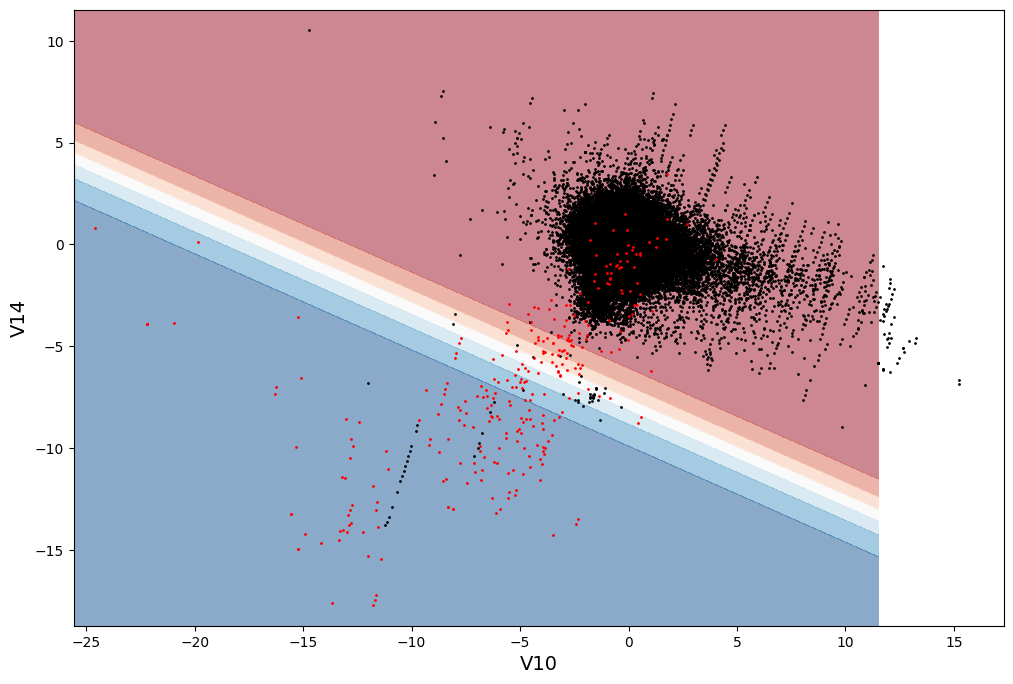

In [25]:
plt.figure(figsize=(12, 8))
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()

**Representación de los ejemplos catalogados como maliciosos**

In [26]:
# Predicción con el conjunto de datos de entrenamiento
y_pred = (model.predict(X_train_reduced)>0.5).astype("int32")

5341/5341 [==============================] - 9s 2ms/step


31250/31250 [==============================] - 60s 2ms/step


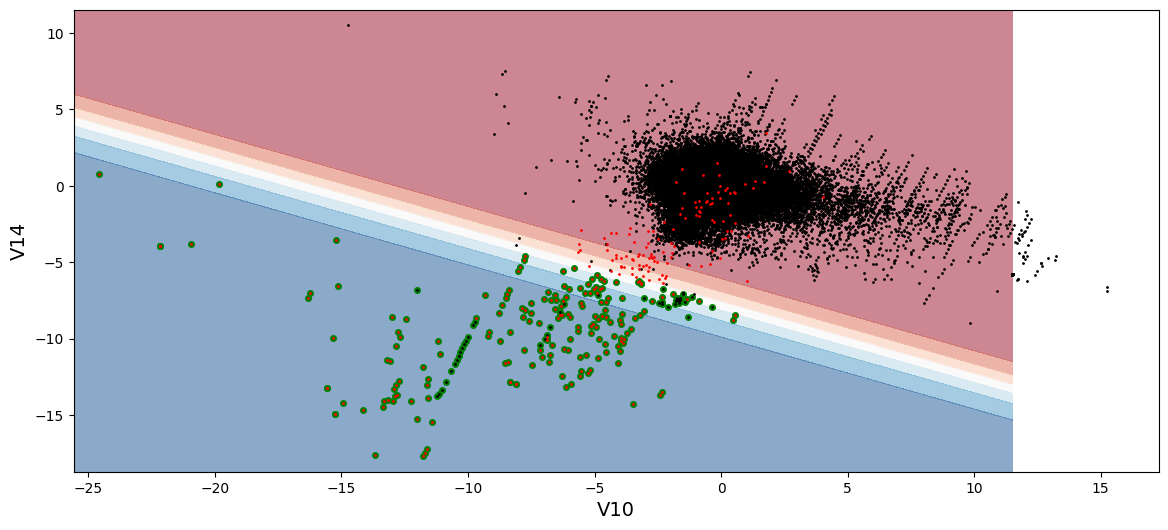

In [27]:
plt.figure(figsize=(14,6))
plt.plot(X_train_reduced[y_pred==1]["V10"], X_train_reduced[y_pred==1]["V14"], 'go', markersize=4)
plot_ann_decision_boundary(X_train_reduced.values, y_train, model)
plt.show()